In [1]:
import torch
from torch import nn
import torch.optim as optim
from fastai.vision.all import *
import matplotlib.pyplot as plt
from models_module import my_models
from train_module import training_functions
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from batchflow.models.torch import TorchModel
from batchflow.models.torch import ResNet, EncoderDecoder
from batchflow.models.torch.layers import ConvBlock

GRAPH_PATH = "./data/graphs/"

In [2]:
in_channels = 3
out_channels = 3
downsample_depth = 4
device = "cuda:3"

batch_size = 50
epoch_num = 50

In [3]:
config = {
    'inputs/images/shape': (in_channels, 32, 32), # can be commented
    'initial_block/inputs': 'images', # can be commented    
    'device': device,

    'body/encoder': {
        'num_stages': downsample_depth,
        'order': ['block', 'downsampling']
    },    
    'body/encoder/blocks': {
        'layout': 'cna cna',
        'filters': [in_channels*pow(2, i) for i in range(1, downsample_depth+1)]
    },
    'body/encoder/downsample': {
        'layout': 'p'
    },    
    
    'body/embedding': {
        'layout': 'cna cna', 
        'filters': in_channels*pow(2, downsample_depth)
    },   

    'body/decoder': {
        'num_stages': downsample_depth, 'skip': False,
        'order': ['upsampling', 'block'] # check        
    },
    'body/decoder/upsample': {
        'layout': 'tna',
        'filters': [in_channels*pow(2, i-1) for i in range(downsample_depth, -1, -1)]
    },
    'body/decoder/combine': {
        'op': 'concat',
        'leading_index': 1
    },
    'body/decoder/blocks': {
        'layout': 'cna cna',
        'filters': [in_channels*pow(2, i-1) for i in range(downsample_depth, -1, -1)]
    },
    'head':{
        'layout': 'ca',
        'filters': in_channels,
        'activation': 'sigmoid'
    },
    
    'loss': 'mse',
    'optimizer': 'Adam'
}

net = EncoderDecoder(config)
train_loss = net.loss[0]
optimizer = net.optimizer
net = net.model

In [4]:
net

Sequential(
  (body): Sequential(
    (encoder): EncoderModule(
      (block-0): ConvBlock(
        (0): DefaultBlock(
          (0): BaseConvBlock(
            layout=cnacna
            
            (Layer 0,  letter "c": (None, 3, 32, 32) -> (None, 6, 32, 32)): Conv(
              (layer): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), bias=False)
            )
            (Layer 1,  letter "n": (None, 6, 32, 32) -> (None, 6, 32, 32)): BatchNorm(
              (layer): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            )
            (Layer 2,  letter "a": (None, 6, 32, 32) -> (None, 6, 32, 32)): Activation(
              (activation): ReLU(inplace=True)
            )
            (Layer 3,  letter "c": (None, 6, 32, 32) -> (None, 6, 32, 32)): Conv(
              (layer): Conv2d(6, 6, kernel_size=(3, 3), stride=(1, 1), bias=False)
            )
            (Layer 4,  letter "n": (None, 6, 32, 32) -> (None, 6, 32, 32)): BatchNorm(
              (

In [5]:
path = URLs.IMAGENETTE_160

In [6]:
trainloader, valloader = training_functions.prepare_train_and_val_dls(path, batch_size, size=160, num_workers=4)

In [7]:
def calculate_loss(dataloader, net, device, criterion):
    """Loss for network inference.
    
    """
    current_loss = 0.0
    steps = 0
    
    for data in dataloader:
        with torch.no_grad():
            inputs, labels = data[0].to(device), data[1].to(device)

            outputs = net(inputs)         
            loss = criterion(outputs, inputs)
            current_loss += loss.cpu().numpy()
            steps += 1

    current_loss /= steps
    return current_loss


In [8]:
def train(net, optimizer, criterion, epoch_num, trainloader, valloader, device, graph_path):
    """Neural network training process.
    
    """
    val_loss_history = []
    train_loss_history = []
    
    for epoch in tqdm(range(epoch_num)):  # loop over the dataset multiple times
        for data in trainloader:
            # get the inputs; data is a list of [inputs, labels]
#             mode.train(inputs, labels)
            inputs, labels = data[0].to(device), data[1].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, inputs)
            loss.backward()
            optimizer.step()
          
        
        # Train accuracy and loss
        current_train_loss = calculate_loss(trainloader, net, device, criterion)     
        train_loss_history.append(current_train_loss)

        # Validation accuracy and loss
        current_val_loss = calculate_loss(valloader, net, device, criterion)     
        val_loss_history.append(current_val_loss)
        
        # visulization:
        if (epoch+1)%5 == 0:
            plt.figure(figsize=(10,7))
            plt.plot(train_loss_history, label=f'Train loss') 
            plt.plot(val_loss_history, label=f'Validation loss') 
            plt.title("Losses")
            plt.xlabel("Epoch number")
            plt.ylabel("Loss")
            plt.grid(True)
            plt.legend()
            plt.tight_layout()
            plt.savefig(graph_path)
            
    return net, {"val losses": val_loss_history, 
                 "train losses": train_loss_history}


CPU times: user 8min 18s, sys: 2min 47s, total: 11min 6s
Wall time: 13min 25s


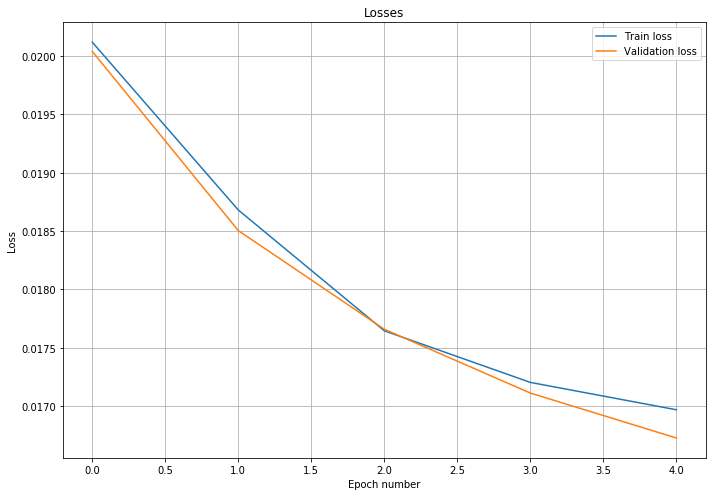

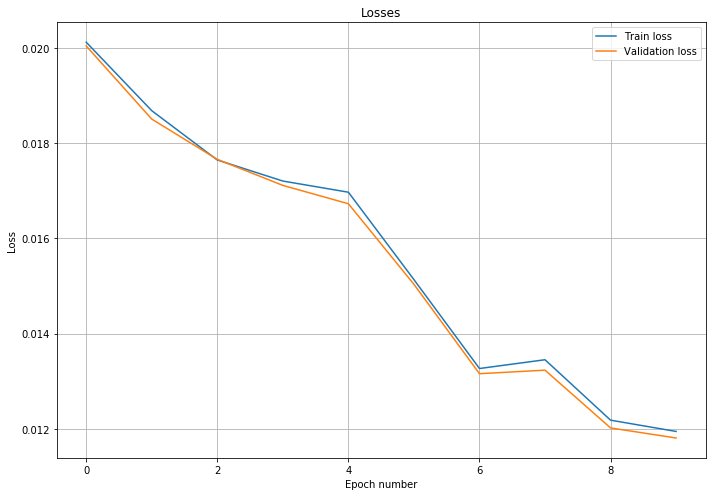

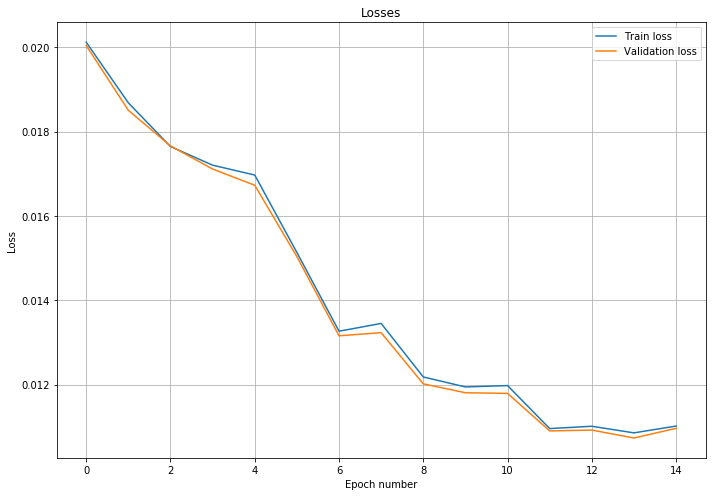

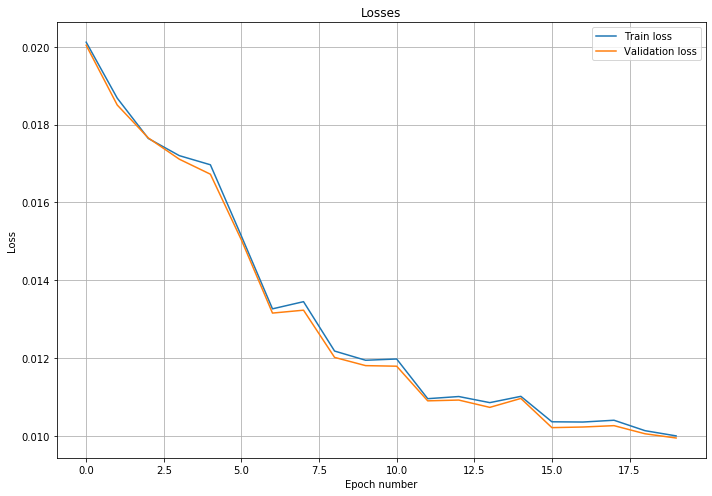

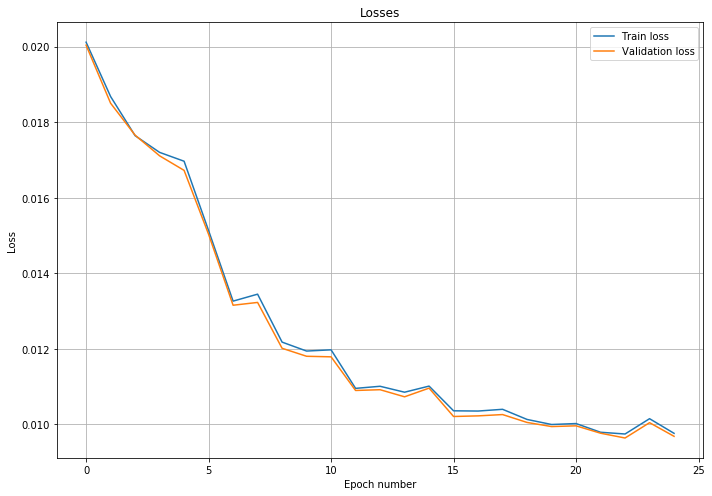

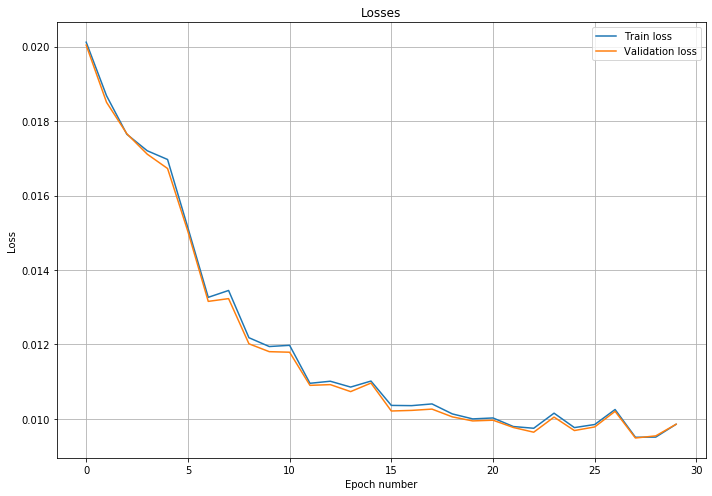

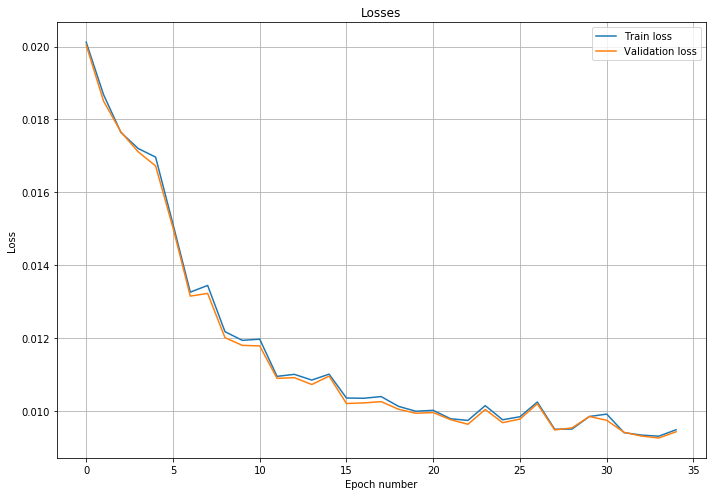

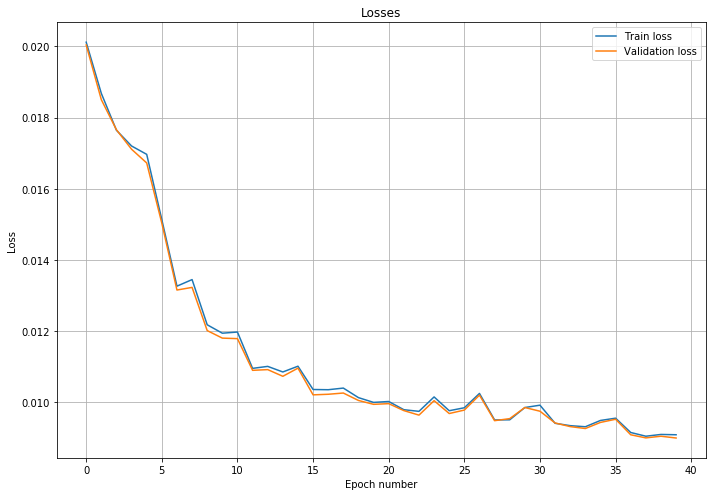

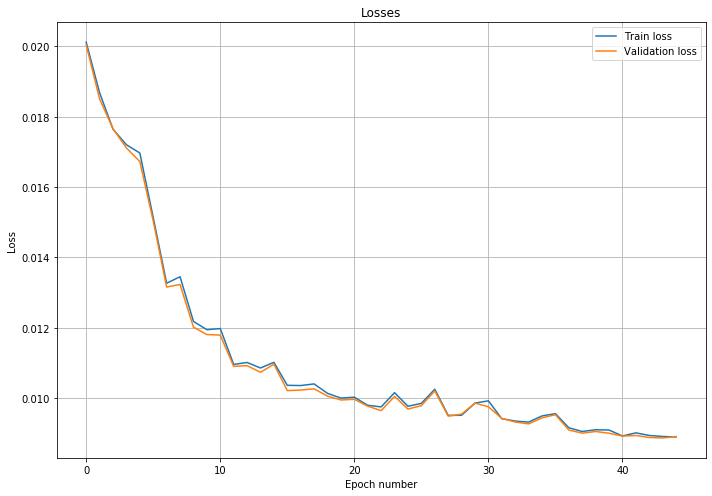

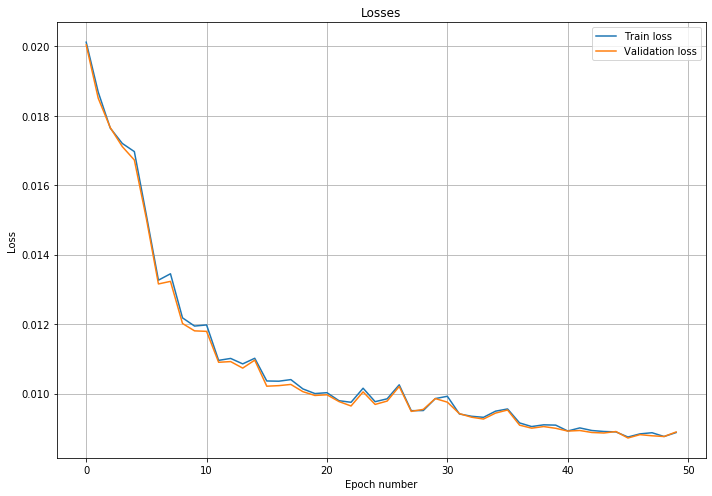

In [9]:
%%time
net, optimization_history = train(net, optimizer, train_loss, epoch_num,
                                  trainloader, valloader, device, GRAPH_PATH+"unet_train_info.jpg")

In [10]:
data, labels = valloader.one_batch()

In [11]:
outputs = net(data.to(device))

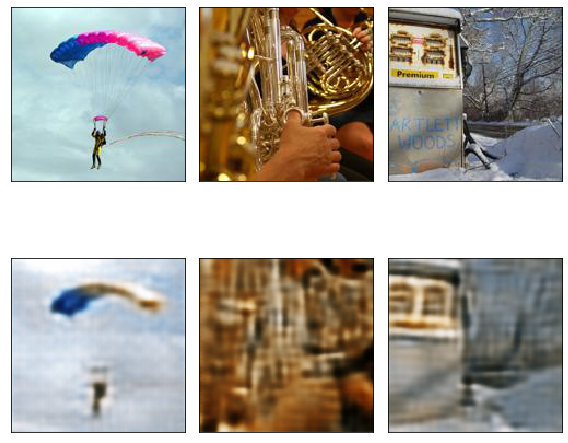

In [12]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(8,8), subplot_kw={'xticks': [], 'yticks': []})

for picture_num, ax in enumerate(axs.flat):
    if picture_num<3:        
        ax.imshow(data[picture_num].cpu().permute(1, 2, 0))
    else:
        ax.imshow(outputs[picture_num-3].detach().cpu().permute(1, 2, 0))


plt.tight_layout()
plt.show()